# MCMC for LMMs with a single vector-valued r.e. term

Creating a Stan model for linear mixed models (LMMs) with time-varying covariates in the random-effects terms requires a model matrix approach.

A simple example of a model with correlated random effects for slope and intercept is analyzed using both the [MixedModels package](https://github.com/dmbates/MixedModels.jl) and [Stan](http://mc-stan.org/) through the [Stan package](https://github.com/goedman/Stan.jl) for [Julia](http://julialang.org)

First we install the MixedModels package

In [1]:
Pkg.add("MixedModels")

INFO: Nothing to be done
INFO: METADATA is out-of-date — you may not have the latest version of MixedModels
INFO: Use `Pkg.update()` to get the latest versions of your packages


In [2]:
using DataFrames,Stan,Mamba,RDatasets,MixedModels

Environment variable JULIA_SVG_BROWSER not found.


In [3]:
const slp = dataset("lme4","sleepstudy")

,Reaction,Days,Subject
1,249.56,0,308
2,258.7047,1,308
3,250.8006,2,308
4,321.4398,3,308
5,356.8519,4,308
6,414.6901,5,308
7,382.2038,6,308
8,290.1486,7,308
9,430.5853,8,308
10,466.3535,9,308


Start with a model for vector-valued random effects for a single grouping factor.  In the `MixedModels` package this would be fit as

In [4]:
m1 = fit(lmm(Reaction ~ 1 + Days + (1+Days|Subject), slp))

Linear mixed model fit by maximum likelihood
Formula: Reaction ~ 1 + Days + ((1 + Days) | Subject)

 logLik: -875.969672, deviance: 1751.939344

 Variance components:
                Variance    Std.Dev.  Corr.
 Subject      565.516376   23.780588
               32.682265    5.716840   0.08
 Residual     654.940901   25.591813
 Number of obs: 180; levels of grouping factors: 18

  Fixed-effects parameters:
             Estimate Std.Error z value
(Intercept)   251.405   6.63228 37.9063
Days          10.4673   1.50224 6.96779


It is very fast to fit such a model

In [5]:
@time fit(lmm(Reaction ~ 1 + Days + (1+Days|Subject), slp));

elapsed time: 0.008524628 seconds (1784296 bytes allocated)


## Creating a stan model

With some help from members of google group _stan-users_ I was able to create a stan formulation.  It is a bit tricky in that this model has random effects for time-varying covariates, `Days` in this case, and you need to form a dot product of the random-effects vector for the m'th `Subject` and a particular row of the random-effects model matrix.

In [Bates et al. (2014)](http://arxiv.org/abs/1406.5823) we describe how we use sparse matrices in the [lme4 package](https://github.com/lme4/lme4) for `R` to "expand" the evaluation of $Z\Lambda u$ across the random effects for each subject.  Matrices $Z$ and $\Lambda$ are both sparse in that formulation.

Here I create `Z` as an `array` of `row_vector`s.  `b` and `u` are arrays of column vectors.  This allows faster access to rows of `Z` and columns of `b` or `u`.


In [18]:
const VectorOne = """
data {
  int<lower=0>  N; // num observations
  int<lower=1>  K; // length of fixed-effects vector
  int<lower=1>  M; // num subjects
  int<lower=1>  J; // length of individual vector-valued random effects
  int<lower=1,upper=M> subj[N]; // subject indicator
  matrix[N,K]   X; // model matrix for fixed-effects parameters
  row_vector[J] Z[N]; // generator model matrix for random-effects
  vector[N]     y; // response vector (reaction time)
}

parameters {
  cholesky_factor_corr[J] L; // Cholesky factor of unconditional correlation of random effects
vector<lower=0>[J] tau;  // relative standard deviations of unconditional distribution of random effects
  vector[J] u[M]; // spherical random effects
  vector[K] beta; // fixed-effects
  real<lower=0> sigma; // standard deviation of response given random effects
}

transformed parameters {
  matrix[J,J] Lambda; 
  matrix[J,J] corr;
  vector[J] b[M];
  vector[N] muX;
  vector[N] mu;
  corr <- tcrossprod(L);  // for monitoring the correlations
  Lambda <- diag_pre_multiply(tau,L);
  for (m in 1:M)
    b[m] <-  Lambda * u[m];
  muX <- X * beta;
  for (n in 1:N)
    mu[n] <- muX[n] + Z[n] * b[subj[n]];
}

model {
  tau ~ cauchy(0,2.5);
  L ~ lkj_corr_cholesky(2);
  for (m in 1:M)
    u[m] ~ normal(0,sigma);
  y ~ normal(mu, sigma);
}
""";

In [7]:
const Xt = vcat(ones(Float64,(1,180)),array(slp[:Days])')

2x180 Array{Float64,2}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  1.0  2.0  3.0  4.0  5.0  6.0  7.0     3.0  4.0  5.0  6.0  7.0  8.0  9.0

In [8]:
const sleepdata = [
    @Compat.Dict("N" => size(slp,1),
    "K" => 2,
    "M" => 18,
    "J" => 2,
    "subj" => slp[:Subject].refs,
    "y" => array(slp[:Reaction]),
    "X" => Xt',
    "Z" => Xt')
]

1-element Array{Dict{ASCIIString,Any},1}:
 ["Z"=>180x2 Array{Float64,2}:
 1.0  0.0
 1.0  1.0
 1.0  2.0
 1.0  3.0
 1.0  4.0
 1.0  5.0
 1.0  6.0
 1.0  7.0
 1.0  8.0
 1.0  9.0
 1.0  0.0
 1.0  1.0
 1.0  2.0
 ⋮       
 1.0  8.0
 1.0  9.0
 1.0  0.0
 1.0  1.0
 1.0  2.0
 1.0  3.0
 1.0  4.0
 1.0  5.0
 1.0  6.0
 1.0  7.0
 1.0  8.0
 1.0  9.0,"J"=>2,"M"=>18,"X"=>180x2 Array{Float64,2}:
 1.0  0.0
 1.0  1.0
 1.0  2.0
 1.0  3.0
 1.0  4.0
 1.0  5.0
 1.0  6.0
 1.0  7.0
 1.0  8.0
 1.0  9.0
 1.0  0.0
 1.0  1.0
 1.0  2.0
 ⋮       
 1.0  8.0
 1.0  9.0
 1.0  0.0
 1.0  1.0
 1.0  2.0
 1.0  3.0
 1.0  4.0
 1.0  5.0
 1.0  6.0
 1.0  7.0
 1.0  8.0
 1.0  9.0,"N"=>180,"subj"=>Uint8[0x01,0x01,0x01,0x01,0x01,0x01,0x01,0x01,0x01,0x01  …  0x12,0x12,0x12,0x12,0x12,0x12,0x12,0x12,0x12,0x12],"K"=>2,"y"=>[249.56,258.705,250.801,321.44,356.852,414.69,382.204,290.149,430.585,466.353  …  269.412,273.474,297.597,310.632,287.173,329.608,334.482,343.22,369.142,364.124]]

In [9]:
stanmodel = Stanmodel(name="VectorOne", model=VectorOne);

In [10]:
sim1 = stan(stanmodel, sleepdata)


make: `/home/juser/notebooks/tmp/VectorOne' is up to date.

Length of data array is not equal to nchains,
all chains will use the first data dictionary.

Inference for Stan model: VectorOne_model
4 chains: each with iter=(1000,1000,1000,1000); warmup=(0,0,0,0); thin=(1,1,1,1); 4000 iterations saved.

Warmup took (8.4, 9.1, 9.9, 9.5) seconds, 37 seconds total
Sampling took (2.1, 2.3, 2.0, 2.4) seconds, 8.7 seconds total

                    Mean     MCSE   StdDev        5%       50%    95%  N_Eff  N_Eff/s    R_hat
lp__            -8.1e+02  2.7e-01  7.3e+00  -8.2e+02  -8.1e+02   -795    715       82  1.0e+00
accept_stat__    9.0e-01  4.2e-03  1.1e-01   6.8e-01   9.4e-01   1.00    687       79  1.0e+00
stepsize__       1.3e-01  7.3e-03  1.0e-02   1.2e-01   1.3e-01   0.14    2.0     0.23  4.4e+13
treedepth__      5.1e+00  6.0e-02  4.5e-01   5.0e+00   5.0e+00    6.0     56      6.4  1.0e+00
n_leapfrog__     3.5e+01  2.1e+00  1.3e+01   3.1e+01   3.1e+01     63     35      4.0  1.0e+00
n_div

Object of type "Chains"

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

1000x455x4 Array{Float64,3}:
[:, :, 1] =
 -799.404  0.943268  0.130129  5.0  …  329.173  342.594  356.015  369.436
 -805.145  0.901871  0.130129  5.0     338.347  350.753  363.159  375.565
 -803.858  0.996836  0.130129  5.0     346.835  359.606  372.378  385.15 
 -795.571  0.970517  0.130129  5.0     330.634  341.736  352.838  363.941
 -789.909  0.928642  0.130129  5.0     332.351  345.57   358.789  372.009
 -793.084  0.939553  0.130129  5.0  …  334.959  345.082  355.205  365.328
 -790.704  0.986368  0.130129  5.0     332.71   345.935  359.161  372.386
 -791.21   0.875209  0.130129  5.0     333.163  344.631  356.099  367.568
 -804.598  0.716931  0.130129  5.0     338.421  350.032  361.643  373.254
 -799.0    0.996003  0.130129  5.0     342.674  357.919  373.165  388.411
 -799.0    0.556629  0.130129  5.0  …  342.674  357.919  373.165  388.411
 -803.482  0.997779  0.130129  5.0 

In [11]:
sim1.names

455-element Array{String,1}:
 "lp__"         
 "accept_stat__"
 "stepsize__"   
 "treedepth__"  
 "n_leapfrog__" 
 "n_divergent__"
 "L.1.1"        
 "L.2.1"        
 "L.1.2"        
 "L.2.2"        
 "tau.1"        
 "tau.2"        
 "u.1.1"        
 ⋮              
 "mu.169"       
 "mu.170"       
 "mu.171"       
 "mu.172"       
 "mu.173"       
 "mu.174"       
 "mu.175"       
 "mu.176"       
 "mu.177"       
 "mu.178"       
 "mu.179"       
 "mu.180"       

In practice it would not make sense to monitor all the parameters and transformed parameters.  We avoid doing so by creating a vector of names to monitor.

In [12]:
monitor = ["lp__", "accept_stat__","corr.2.1","tau.1","tau.2","sigma","beta.1","beta.2"]

8-element Array{ASCIIString,1}:
 "lp__"         
 "accept_stat__"
 "corr.2.1"     
 "tau.1"        
 "tau.2"        
 "sigma"        
 "beta.1"       
 "beta.2"       

In [19]:
stanmodel = Stanmodel(name="VectorOne", model=VectorOne, monitors=monitor);


File /home/juser/notebooks/tmp/VectorOne.stan will be updated.



In [20]:
sim1 = stan(stanmodel,sleepdata)



--- Translating Stan model to C++ code ---
bin/stanc /home/juser/notebooks/tmp/VectorOne.stan --o=/home/juser/notebooks/tmp/VectorOne.cpp --no_main
Model name=VectorOne_model
Input file=/home/juser/notebooks/tmp/VectorOne.stan
Output file=/home/juser/notebooks/tmp/VectorOne.cpp

--- Linking C++ model ---
g++ -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -I src -I stan/src -isystem stan/lib/eigen_3.2.0 -isystem stan/lib/boost_1.54.0 -Wall -pipe -DEIGEN_NO_DEBUG -Wno-unused-local-typedefs  -lpthread  -O3 -o /home/juser/notebooks/tmp/VectorOne src/cmdstan/main.cpp -include /home/juser/notebooks/tmp/VectorOne.cpp -Lbin -lstan

Length of data array is not equal to nchains,
all chains will use the first data dictionary.

Inference for Stan model: VectorOne_model
4 chains: each with iter=(1000,1000,1000,1000); warmup=(0,0,0,0); thin=(1,1,1,1); 4000 iterations saved.

Warmup took (8.2, 8.1, 7.8, 8.3) seconds, 32 seconds total
Sampling took (1.9, 2.2, 2.2, 2.2) seconds

Object of type "Chains"

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

1000x8x4 Array{Float64,3}:
[:, :, 1] =
 -815.023  0.987648  0.896668  0.181104  …  12.7808   25.6504   0.45231   
 -813.342  0.886428  0.851193  0.215938     11.8049   25.6113   0.263393  
 -810.87   0.842526  1.02923   0.26072      10.8029   25.3286   0.0206116 
 -815.136  0.670628  0.745223  0.269103      9.72912  27.0287   0.056959  
 -811.896  0.97152   0.649326  0.250041     10.0434   25.2539   0.167035  
 -817.103  0.985944  0.524091  0.274564  …  10.0743   29.7675  -0.052883  
 -818.705  0.660574  0.473632  0.256668      9.87716  29.5031  -0.0279245 
 -807.794  0.971579  1.12008   0.319091     10.5394   26.0206  -0.315786  
 -806.25   0.820849  0.684993  0.260816     12.0691   26.9025   0.145627  
 -815.06   0.74875   1.05826   0.191546     13.3086   25.2369   0.00141595
 -805.724  0.980911  1.03761   0.225117  …  14.1454   24.7272  -0.101423  
 -800.552  0.966567  1.245

In [21]:
describe(sim1)

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Empirical Posterior Estimates:
9x6 Array{Any,2}:
 ""                   "Mean"     "SD"      "Naive SE"   "MCSE"         "ESS"
 "lp__"           -807.828      7.5961    0.120105     0.277928    1728.57  
 "accept_stat__"     0.896303   0.113413  0.00179321   0.00175701  4000.0   
 "tau.1"             1.04256    0.273073  0.00431767   0.00746214  2314.44  
 "tau.2"             0.253289   0.059964  0.000948114  0.00110521  3431.44  
 "beta.1"          251.609      7.63272   0.120684     0.206854    2333.7   
 "beta.2"           10.4613     1.72229   0.0272318    0.044787    2432.12  
 "sigma"            25.8292     1.50269   0.0237597    0.0367744   2584.37  
 "corr.2.1"          0.0747349  0.280506  0.00443518   0.00937178  1893.0   

Quantiles:
9x6 Array{Any,2}:
 ""                   "2.5%"       "25.0%"  …      "75.0%"      "97.5%"
 "lp__"           -823.751     -812.859        -802.429     -794.258   

In [22]:
p = plot(sim1,[:trace,:density]);

 in traceplot at /home/juser/.julia/v0.3/Mamba/src/output/plot.jl:26
 in plot at /home/juser/.julia/v0.3/Mamba/src/output/plot.jl:13
 in plot at /home/juser/.julia/v0.3/Mamba/src/output/plot.jl:7
 in include_string at loading.jl:97
 in execute_request_0x535c5df2 at /home/juser/.julia/v0.3/IJulia/src/execute_request.jl:160
 in eventloop at /home/juser/.julia/v0.3/IJulia/src/IJulia.jl:123
 in anonymous at task.jl:340
 in traceplot at /home/juser/.julia/v0.3/Mamba/src/output/plot.jl:26
 in plot at /home/juser/.julia/v0.3/Mamba/src/output/plot.jl:13
 in plot at /home/juser/.julia/v0.3/Mamba/src/output/plot.jl:7
 in include_string at loading.jl:97
 in execute_request_0x535c5df2 at /home/juser/.julia/v0.3/IJulia/src/execute_request.jl:160
 in eventloop at /home/juser/.julia/v0.3/IJulia/src/IJulia.jl:123
 in anonymous at task.jl:340
 in traceplot at /home/juser/.julia/v0.3/Mamba/src/output/plot.jl:26
 in plot at /home/juser/.julia/v0.3/Mamba/src/output/plot.jl:13
 in plot at /home/juser/.juli

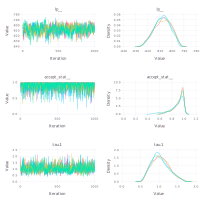

STDIN> 


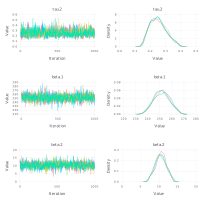

STDIN> 


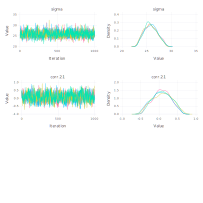

Press ENTER to draw next plot
Press ENTER to draw next plot


In [23]:
draw(p)